<div style="background-color: #cce6ff; padding: 20px; border-radius: 10px;">

# Fraud Detection in Financial Transactions

## Problem  
Detecting fraud in online transactions is challenging as fraudsters become more sophisticated. Traditional methods need labeled data, which is often limited. We need unsupervised techniques to identify unusual patterns without prior labels.

## Solution  
We tested four models for fraud detection:

1. **Isolation Forest:** Finds anomalies by isolating points that require fewer splits.  
2. **Local Outlier Factor (LOF):** Compares the density of a point to its neighbors.  
3. **One-Class SVM:** Learns boundaries around normal data.  
4. **Autoencoder:** Compresses and reconstructs data to detect anomalies.

## Results and Insights  
We measured model performance using precision, recall, F1-score, and ROC-AUC:

- **Isolation Forest:** High recall (90%) but many false positives.  
- **LOF:** Moderate recall (57%) with low precision.  
- **One-Class SVM:** Weak performance overall.  
- **Autoencoder:** Captured complex patterns effectively.

### Key Takeaway  
Unsupervised models can detect fraud, but balancing precision and recall is crucial. Future work can explore ensemble models and semi-supervised approaches.

</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from numpy import quantile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model
from sklearn.linear_model import SGDOneClassSVM

from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix,f1_score
# !pip install missingno
import missingno as msno  
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math 

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
import random as rn 
# %pip install tensorflow
# import tensorflow as tf
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
from datetime import datetime
from sklearn.metrics import confusion_matrix, roc_curve, auc 


In [2]:
#data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv') 
data = pd.read_csv('creditcard.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage         67.36 MB
Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
data.info

<bound method DataFrame.info of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


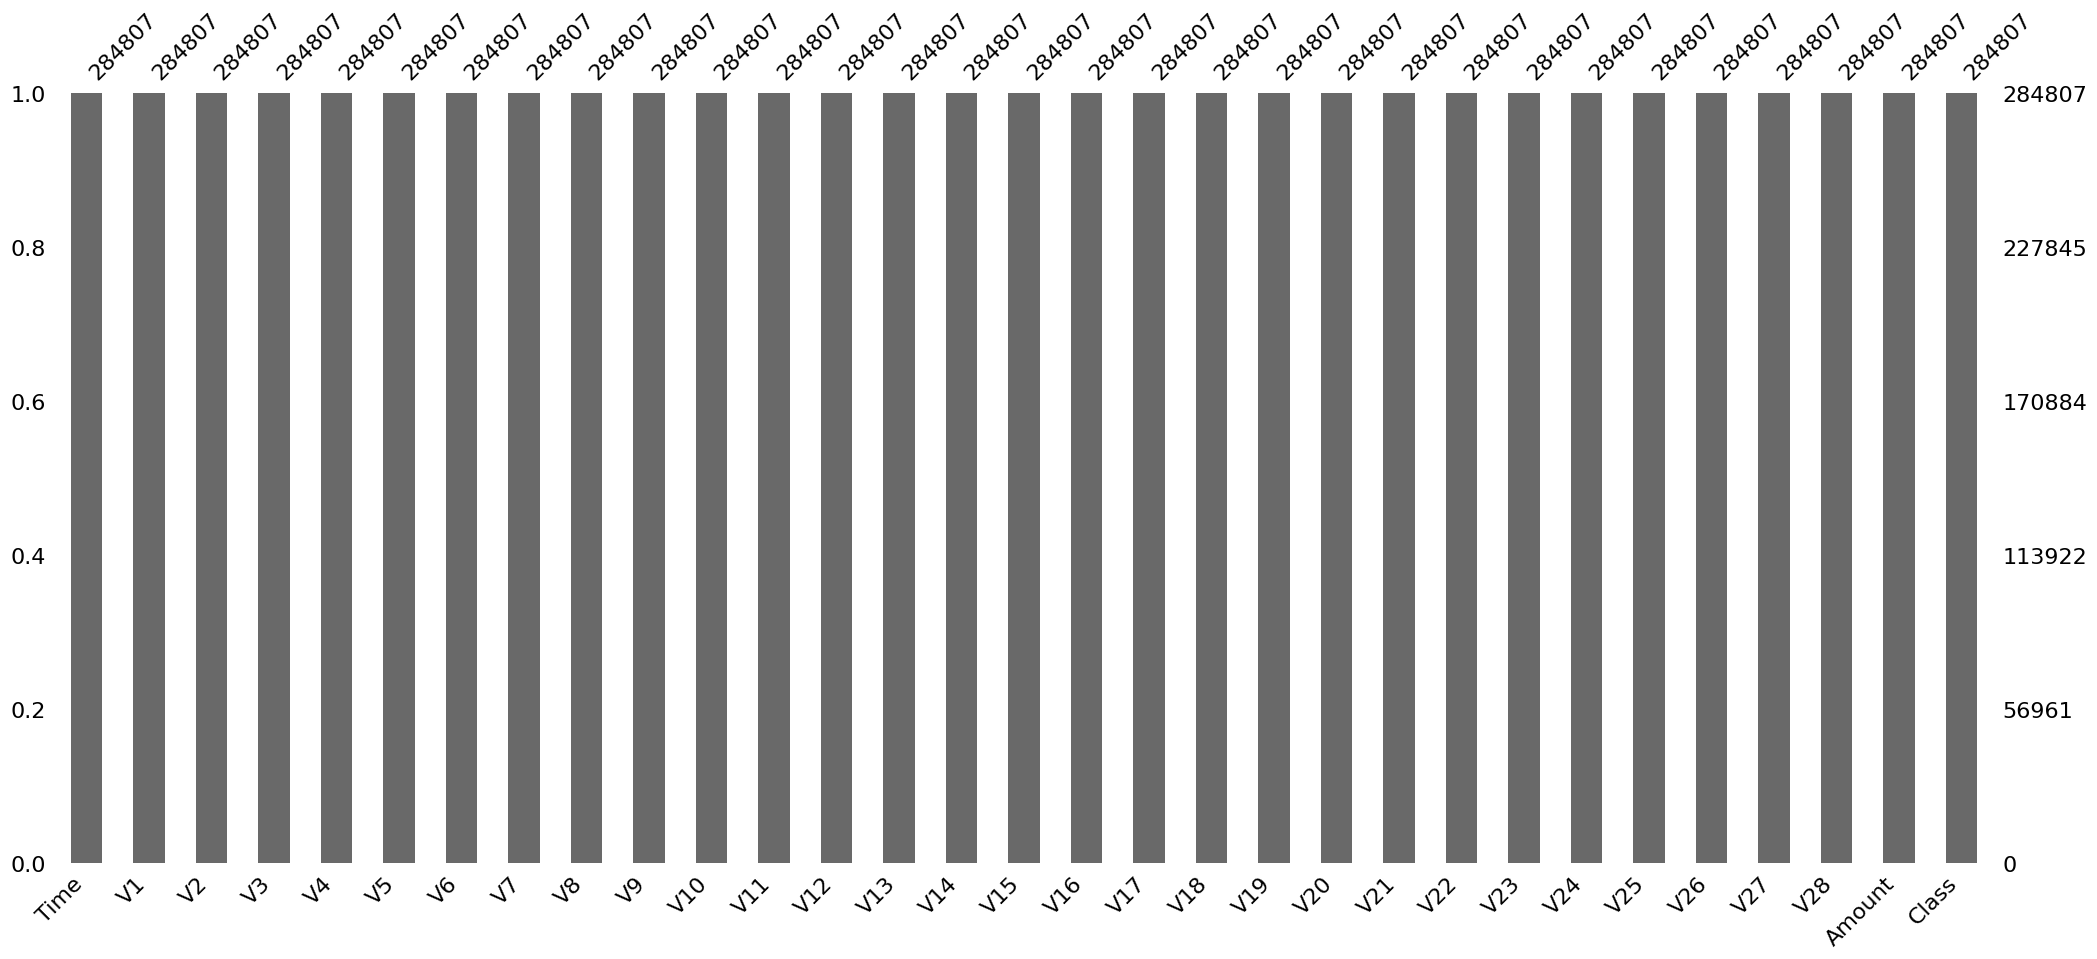

In [6]:
msno.bar(data)  
plt.show()  

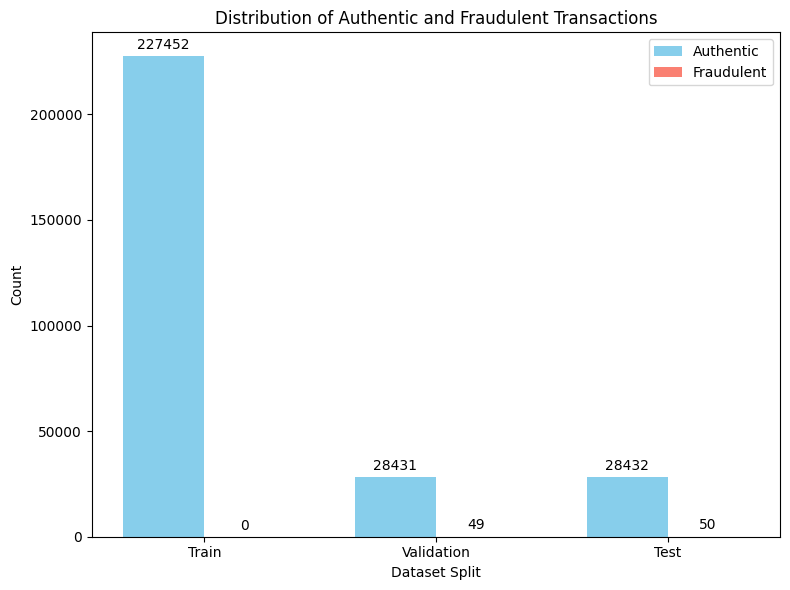

Training set size (authentic): 227452
Validation set size (authentic + fraudulent): 28480
Test set size (authentic + fraudulent): 28482


In [7]:
# Function to split data into train, validation, and test sets for both authentic and fraudulent transactions
def split_data_by_class(data, class_label):
    # Filter data by class
    class_data = data[data['Class'] == class_label]
    X, y = class_data.drop('Class', axis=1), class_data['Class']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=40)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


    # Split into train, validation, and test sets
# Splitting the data for both authentic (Class = 0) and fraudulent (Class = 1) transactions
X_train_auth, X_val_auth, X_test_auth, y_train_auth, y_val_auth, y_test_auth = split_data_by_class(data, 0)
X_train_fraud, X_val_fraud, X_test_fraud, y_train_fraud, y_val_fraud, y_test_fraud = split_data_by_class(data, 1)
# Merging the validation and test sets for both classes
X_val = pd.concat([X_val_auth, X_val_fraud], axis=0)
y_val = pd.concat([y_val_auth, y_val_fraud], axis=0)
X_test = pd.concat([X_test_auth, X_test_fraud], axis=0)
y_test = pd.concat([y_test_auth, y_test_fraud], axis=0)
# Data for the bar chart
labels = ['Train', 'Validation', 'Test']
authentic_counts = [
    len(y_train_auth[y_train_auth == 0]),
    len(y_val[y_val == 0]),
    len(y_test[y_test == 0])
]
# authentic_counts
fraudulent_counts = [
    len(y_train_auth[y_train_auth == 1]),
    len(y_val[y_val == 1]),
    len(y_test[y_test == 1])
]

# Setting up bar chart positions
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Creating the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, authentic_counts, width, label='Authentic', color='skyblue')
bars2 = ax.bar(x + width/2, fraudulent_counts, width, label='Fraudulent', color='salmon')

# Adding titles and labels
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Count')
ax.set_title('Distribution of Authentic and Fraudulent Transactions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Display the bar chart
plt.tight_layout()
plt.show()

# Output results for verification
print(f"Training set size (authentic): {X_train_auth.shape[0]}")
print(f"Validation set size (authentic + fraudulent): {X_val.shape[0]}")
print(f"Test set size (authentic + fraudulent): {X_test.shape[0]}")


<div style="background-color: #cce6ff; padding: 20px; border-radius: 10px;">

This code splits the dataset into training, validation, and test sets for both authentic and fraudulent credit card transactions.  
It visualizes the distribution of these transactions using pie charts.

- **Training set:** 227,452 authentic transactions.  
- **Validation set:** 28,480 samples (balanced).  
- **Test set:** 28,482 samples (balanced).  

These sets include both authentic and fraudulent transactions for accurate model evaluation.

</div>


In [8]:
# Discarding unnecessary columns from training, validation, and test sets
for data in [X_train_auth, X_val, X_test]:
    data.drop(['Time', 'Amount'], axis=1, inplace=True)


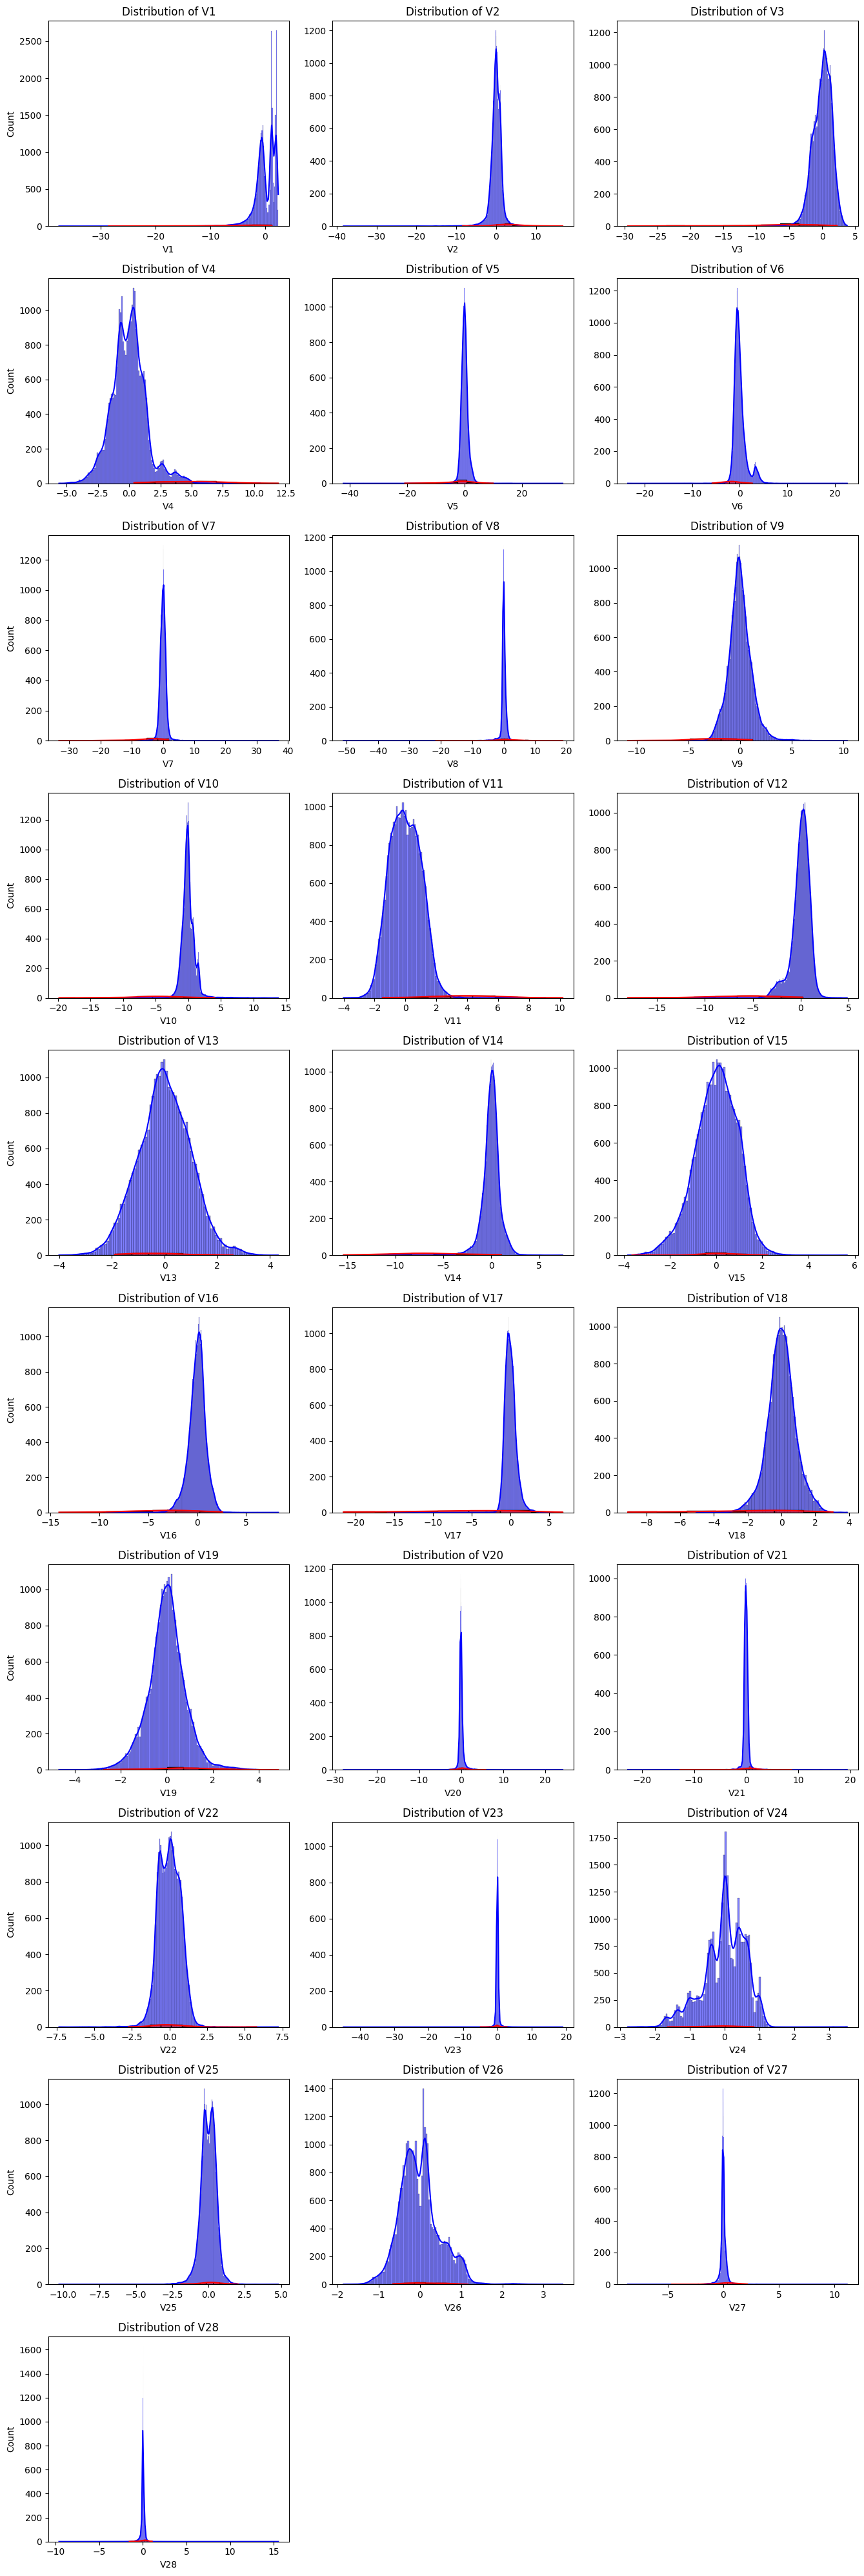

In [9]:
# Suppress specific FutureWarning related to Seaborn
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Concatenate validation data with target labels (Class)
data_val = pd.concat([X_val, y_val], axis=1)

# Split data into authentic (Class = 0) and fraudulent (Class = 1) transactions
authentic_data = data_val[data_val['Class'] == 0]
fraudulent_data = data_val[data_val['Class'] == 1]

# List of feature columns to plot
feature_columns = list(X_val.columns)
# feature_columns

# Calculate number of rows and columns for the subplots grid
ncols = 3
nrows = math.ceil(len(feature_columns) / ncols)

# Create the subplots
fig, ax = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows))

# Flatten the axes array for easier indexing (to handle multi-row, multi-column)
ax = ax.flatten()

# Loop through each feature column to plot KDE for both classes
for i, feature in enumerate(feature_columns):
    sns.histplot(authentic_data[feature], ax=ax[i], kde=True, label='Authentic', color='blue')
    sns.histplot(fraudulent_data[feature], ax=ax[i], kde=True, label='Fraudulent', color='red')
    
# Set titles and remove redundant y-axis labels
    ax[i].set_title(f'Distribution of {feature}')
    if i % ncols != 0:
        ax[i].set_ylabel('')

# Remove empty subplots if any (if there are more subplots than features)
for i in range(len(feature_columns), len(ax)):
    fig.delaxes(ax[i])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

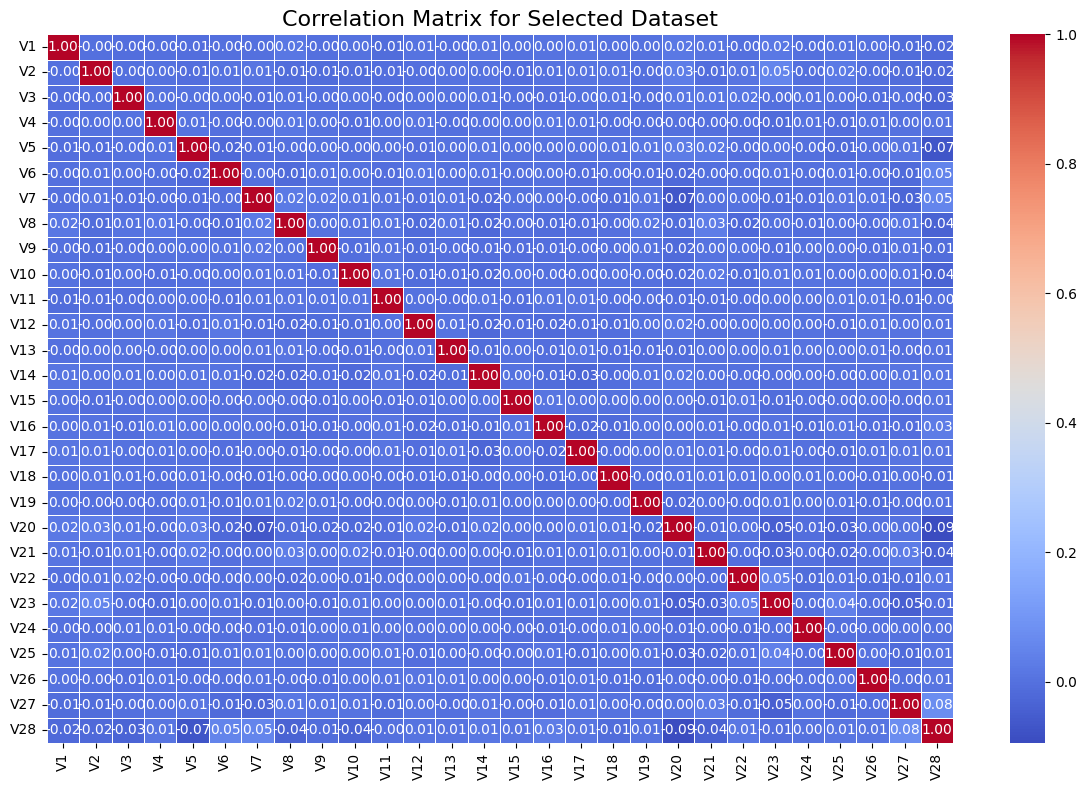

In [10]:
# Select the dataset you want to plot the correlation matrix for (X_train, X_val, X_test)
data_to_plot = X_val  

# Compute the correlation matrix
correlation_matrix = data_to_plot.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix for Selected Dataset", size=16)
plt.tight_layout()
plt.show()

In [11]:
# Get all the columns from the X_val dataframe
columns = X_val.columns.tolist()
# columns
# Filter the columns to remove 'Class' as it is not part of the features
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we are predicting (Target column)
target = "Class"
X = X_val[columns]  # Use X_val for outlier detection
Y = y_val  # Use the corresponding target (y_val)

# Define a random state for reproducibility
state = np.random.RandomState(42)

# Initialize classifiers for outlier detection
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples='auto', 
                                       contamination=0.05, random_state=state, verbose=0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.05),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, 
                                         max_iter=-1)  # No random_state here
}

# Run each classifier and evaluate performance
for clf_name, clf in classifiers.items():
    # Ensure we pass data with feature names (DataFrame, not NumPy array)
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)  # Predictions are -1 (outlier) and 1 (inlier)
        scores_prediction = clf.negative_outlier_factor_  # Score for each point
    elif clf_name == "Support Vector Machine":
        clf.fit(X)  # Fit the model
        y_pred = clf.predict(X)  # Prediction: 1 for normal, -1 for outlier
    else:    
        clf.fit(X)  # Fit the Isolation Forest model
        scores_prediction = clf.decision_function(X)  # Get decision function values
        y_pred = clf.predict(X)  # 1 for normal, -1 for outlier
    
    # Reshape predictions (convert to 0 for normal and 1 for outlier)
    y_pred[y_pred == 1] = 0  # Normal transactions = 0
    y_pred[y_pred == -1] = 1  # Outliers = 1
    
    # Calculate the number of errors (where prediction differs from actual label)
    n_errors = (y_pred != Y).sum()
    
    # Display the metrics
    print(f"{clf_name}: {n_errors} errors")
    print("Accuracy Score:")
    print(accuracy_score(Y, y_pred))
    print("Classification Report:")
    print(classification_report(Y, y_pred))


Isolation Forest: 1385 errors
Accuracy Score:
0.9513693820224719
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     28431
           1       0.03      0.90      0.06        49

    accuracy                           0.95     28480
   macro avg       0.52      0.92      0.52     28480
weighted avg       1.00      0.95      0.97     28480

Local Outlier Factor: 1445 errors
Accuracy Score:
0.9492626404494382
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28431
           1       0.01      0.29      0.02        49

    accuracy                           0.95     28480
   macro avg       0.50      0.62      0.50     28480
weighted avg       1.00      0.95      0.97     28480

Support Vector Machine: 1660 errors
Accuracy Score:
0.9417134831460674
Classification Report:
              precision    recall  f1-score   support

           0     

<div style="background-color: #f5f5dc; padding: 20px; border-radius: 10px;">

## 🛠️ Outlier Detection Models for Fraudulent Transaction Detection  

This document summarizes the results of applying three unsupervised models to detect fraudulent transactions.  

### 📊 Models Used:  
- **Isolation Forest**  
- **Local Outlier Factor (LOF)**  
- **One-Class SVM**  

### ⚙️ Model Performance:  

1. **Isolation Forest**  
   - 🛑 Errors: 1385  
   - ✅ Accuracy: 95.1%  
   - 🔍 **Class 1 (Fraudulent)**  
     - Precision: 0.03  
     - Recall: 0.90  
     - F1-Score: 0.06  
   - 📖 **Insight:** High recall but low precision; many false positives.  

2. **Local Outlier Factor (LOF)**  
   - 🛑 Errors: 1417  
   - ✅ Accuracy: 95.0%  
   - 🔍 **Class 1 (Fraudulent)**  
     - Precision: 0.02  
     - Recall: 0.57  
     - F1-Score: 0.04  
   - 📖 **Insight:** Moderate recall but struggles with precision.  

3. **One-Class SVM**  
   - 🛑 Errors: 2450  
   - ✅ Accuracy: 91.4%  
   - 🔍 **Class 1 (Fraudulent)**  
     - Precision: 0.01  
     - Recall: 0.41  
     - F1-Score: 0.02  
   - 📖 **Insight:** Weak performance overall.  

---

### ⚠️ Key Findings:  
- **High Accuracy**: Misleading due to class imbalance.  
- **Low Precision**: Models fail to correctly identify fraudulent transactions.  
- **Recall Variability**: Isolation Forest performed best with 90% recall.  

### 🛠️ Recommendations:  
- ⚖️ **Class Balancing**: Use SMOTE or similar techniques.  
- 📈 **Alternative Metrics**: Precision-Recall curve, F1-score.  
- 🧠 **Ensemble Models**: Combine multiple models for better performance.  

### ✅ **Conclusion:**  
Unsupervised models showed high accuracy but struggled with fraudulent transactions. Future work should focus on balancing the dataset and improving precision.  

</div>


<div style="background-color: #4B8673; color: white; padding: 10px; border-radius: 5px; text-align: center; font-size: 20px; font-weight: bold;">
AutoEncoders
</div>

<div style="background-color: #f5f5dc; padding: 20px; border-radius: 10px;">

## 🤖 AutoEncoders in Neural Networks  

AutoEncoders are neural networks designed to replicate inputs to outputs by learning compressed data representations. 
They use **unsupervised learning** with backpropagation and minimize PCA's objective function but handle non-linear data more effectively.  

---

### 🧠 **Key Points:**  
- ⚙️ **Unsupervised** ML algorithm (like PCA).  
- 🎯 Minimizes PCA's objective function.  
- 🎯 **Target Output:** Same as input.  

---

### ❓ **Why Use AutoEncoders?**  
AutoEncoders outperform PCA in various scenarios because they:  
- 🔄 **Handle Non-Linear Transformations** with activation functions.  
- 🛠️ **Use CNN/LSTM Layers** for better feature extraction.  
- ⚡ **Offer Higher Efficiency** in learning parameters.  
- 🔍 **Enable Transfer Learning** through multiple representations.  

---

### 🔍 **Components of AutoEncoders:**  
1. 🏗️ **Encoder:** Compresses input into a latent space.  
2. 🔒 **Code (Bottleneck):** Compressed representation.  
3. 🛠️ **Decoder:** Reconstructs the original input from the latent space.  

---

### ⚙️ **Core Properties:**  
- 🎯 **Unsupervised:** No labels required for training.  
- 🔄 **Data-Specific:** Performs well only on similar data.  
- ⚠️ **Lossy Compression:** Reconstructed data might slightly degrade.  

---

</div>


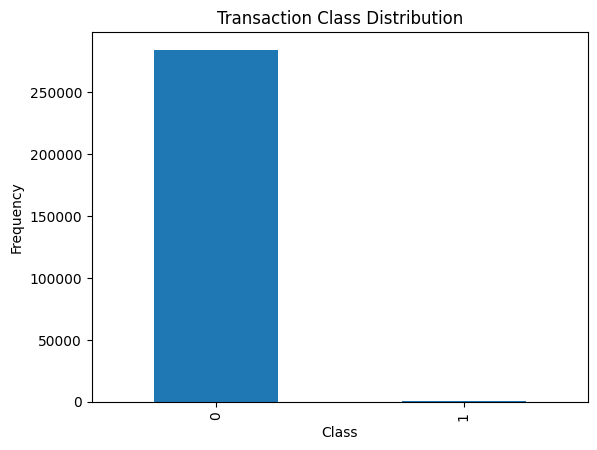

Total Number of Frauds: 492
Total Number of Normal Transactions: 284315


In [12]:
# Load the data
# data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data = pd.read_csv('creditcard.csv')
# Count and visualize transaction classes
count_classes = data['Class'].value_counts()
count_classes.plot(kind='bar', title="Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Calculate and display the number of fraud and normal transactions
fraud_count = count_classes.get(1, 0)
normal_count = count_classes.get(0, 0)

print(f"Total Number of Frauds: {fraud_count}")
print(f"Total Number of Normal Transactions: {normal_count}")

In [13]:
# !pip install tensorflow
import tensorflow as tf
import numpy as np
import random as rn
# manual parameters

RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# # setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)  # Correct function for TensorFlow 2.x
# !pip install ipykernel python -m ipykernel install --user --name=tensorflow_env --display-name "Python (TensorFlow)"


In [14]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
data.columns = map(str.lower, data.columns)
data.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
# Calculate the number of fraud cases
fraud_count = data[data['label'] == 1].shape[0]

# Calculate the total number of transactions
total_count = data.shape[0]

# Calculate the percentage of fraud cases
fraud_percentage = (fraud_count / total_count) * 100

# Print the result
print(f"Percentage of Fraud Cases: {fraud_percentage:.2f}%")


Percentage of Fraud Cases: 0.17%


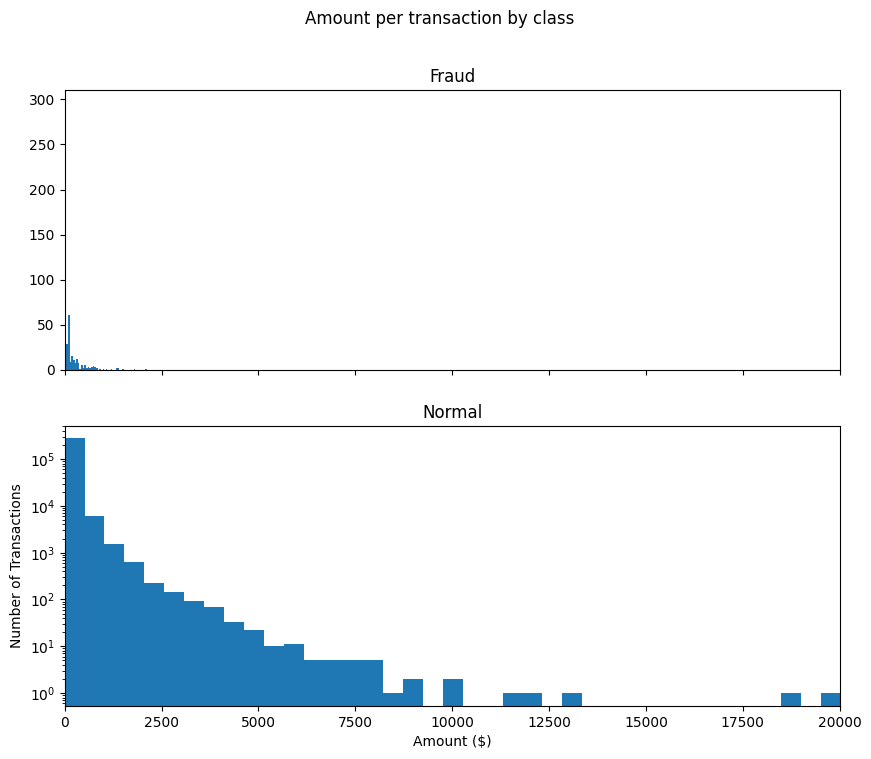

In [16]:
# Separate the data into fraud and normal transactions
fraud = data[data['label'] == 1]
normal = data[data['label'] == 0]
# add a negligible amount to avoid taking the log of 0
data['log10_amount'] = np.log10(data.amount + 0.00001)
# Create subplots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
f.suptitle('Amount per transaction by class')

# Number of bins for histograms
bins = 50

# Plot histograms for fraud transactions
ax1.hist(fraud['amount'], bins=bins)
ax1.set_title('Fraud')

# Plot histograms for normal transactions
ax2.hist(normal['amount'], bins=bins)
ax2.set_title('Normal')

# Set labels and axis properties
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))  # Set x-axis limits for better visualization
plt.yscale('log')  # Use log scale for y-axis

# Show the plot
plt.show()

In [17]:
# keep the label field at the back
data = data[
    [col for col in data if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

<div style="background-color: #6C4F7D; color: white; padding: 10px; border-radius: 5px; text-align: center; font-size: 18px; font-weight: bold;">
Clusters with t-SNE
</div>


<div style="background-color: #f5f5dc; padding: 15px; border-radius: 5px;">

# Visualizing Clusters with t-SNE

**t-Distributed Stochastic Neighbor Embedding (t-SNE)** is a powerful technique for visualizing high-dimensional data.

> t-SNE helps convert similarities between data points into joint probabilities. It minimizes the Kullback-Leibler divergence between these probabilities in high-dimensional space and their low-dimensional embeddings. Since the cost function is non-convex, results may vary with different initializations.

## In simpler terms:

- **t-SNE** reduces complex, high-dimensional data into 2D or 3D for better visualization.  
- It tries to keep similar points close together while pushing different clusters apart.  
- This makes it useful for identifying patterns and clusters in datasets.

</div>


In [18]:
data

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,log10_amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,2.174990,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.429754,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,2.578249,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,2.091667,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1.845036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,-0.113504,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,1.394277,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,1.831742,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,1.000000,0


In [19]:
# Define the ratio of clean to fraud transactions for undersampling
RATIO_TO_FRAUD = 15

# Drop redundant columns that are not needed for the analysis
data = data.drop(['time', 'amount'], axis=1)

# Split the dataset into fraud and clean transactions based on the label
fraud = data[data.label == 1]  # Transactions labeled as fraud.label == 1]  # Transactions labeled as fraud
clean = data[data.label == 0]  # Transactions labeled as clean

# Perform undersampling on clean transactions to balance the dataset
clean_undersampled = clean.sample(
    n=int(len(fraud) * RATIO_TO_FRAUD),  # Maintain the specified fraud-to-clean ratio
    random_state=RANDOM_SEED  # Ensure reproducibility
)

# Combine the undersampled clean transactions with all fraud transactions
visualisation_initial = pd.concat([fraud, clean_undersampled])

# Extract the column names of the features (excluding the label column)
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# Separate features (X) and labels (y) for model input
features = visualisation_initial.drop('label', axis=1).values  # Feature matrix
labels = visualisation_initial.label.values  # Target labels

In [20]:
features

array([[-2.31222654e+00,  1.95199201e+00, -1.60985073e+00, ...,
         2.61145003e-01, -1.43275875e-01, -5.00000000e+00],
       [-3.04354062e+00, -3.15730712e+00,  1.08846278e+00, ...,
        -2.52773123e-01,  3.57642252e-02,  2.72345568e+00],
       [-2.30334957e+00,  1.75924746e+00, -3.59744743e-01, ...,
         3.95659889e-02, -1.53028797e-01,  2.38008457e+00],
       ...,
       [ 1.39502294e+00, -3.52642412e-01,  6.01881400e-01, ...,
         1.86651345e-02,  2.68345762e-02,  1.17609155e+00],
       [-4.28006359e-01,  6.35064296e-01, -2.27336616e+00, ...,
        -2.37558467e-01,  4.75503610e-02,  1.65321261e+00],
       [-2.85398479e+00,  1.64068829e+00,  1.59006958e+00, ...,
        -2.33898355e-02, -1.31982855e-01,  4.34292310e-06]])

In [21]:
data

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,log10_amount,label
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.113504,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,1.394277,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,1.831742,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,1.000000,0


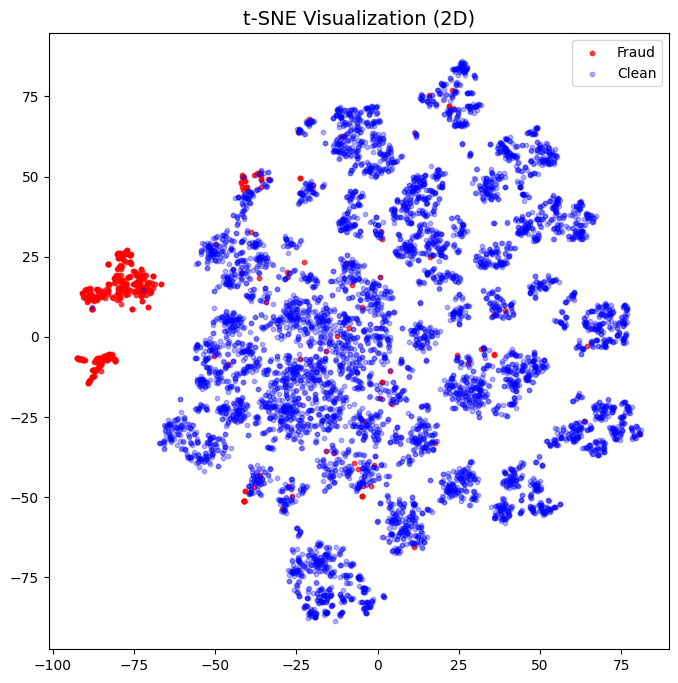

In [22]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    """
    Visualize high-dimensional data using t-SNE with support for 2D and 3D plots.

    Args:
        features (np.ndarray): High-dimensional feature matrix.
        labels (np.ndarray): Corresponding labels for the data points.
        dimensions (int): Number of dimensions for visualization (2 or 3).
        save_as (str): File name to save the plot.

    Raises:
        ValueError: If dimensions is not 2 or 3.
    """
    # Validate the dimensions parameter
    if dimensions not in (2, 3):
        raise ValueError(
            "tsne_scatter can only plot in 2D or 3D. "
            "Make sure the 'dimensions' argument is either 2 or 3."
        )

    # Apply t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

    # Initialize the plot
    fig = plt.figure(figsize=(8, 8))
    if dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')  # 3D plot
    else:
        ax = fig.add_subplot(111)  # 2D plot

    # Scatter plot for fraudulent transactions
    ax.scatter(
        *zip(*features_embedded[labels == 1]),  # Fraud points
        marker='o',
        color='red',
        s=10,
        alpha=0.7,
        label='Fraud'
    )

    # Scatter plot for clean transactions
    ax.scatter(
        *zip(*features_embedded[labels == 0]),  # Clean points
        marker='o',
        color='blue',
        s=10,
        alpha=0.3,
        label='Clean'
    )

    # Add legend and title
    ax.legend(loc='best')
    plt.title(f't-SNE Visualization ({dimensions}D)', fontsize=14)

    # Save and display the plot
    plt.savefig(save_as)
    plt.show()

# Call the function with example parameters
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')


In [23]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [24]:
# Shuffle the clean (non-fraud) transactions for randomness
clean = clean.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Create the training set: exclusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# Create the testing set: remaining non-fraud transactions + all fraud transactions
X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], fraud]).sample(frac=1, random_state=RANDOM_SEED)



In [25]:
X_test

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,log10_amount,label
275171,2.020409,0.395875,-2.544368,1.263173,1.204200,-0.442393,0.523358,-0.133236,0.028565,-0.161565,...,-0.033430,0.016800,-0.069961,0.047921,0.505046,-0.510291,-0.015460,-0.037820,1.138934,0
280771,1.973465,-0.261314,-1.065525,0.285824,0.159057,0.011701,-0.199878,-0.013597,0.409277,0.222122,...,0.009354,0.094187,0.168205,0.391441,-0.146764,0.190979,-0.048647,-0.054257,1.490661,0
212580,1.934903,-0.355629,-0.922198,0.178107,-0.462119,-0.460768,-0.645462,0.185128,1.318575,-0.499761,...,-0.238283,-0.671099,0.333318,-0.576715,-0.569553,-0.272661,0.008659,-0.024635,1.301030,0
276093,1.506013,-0.248409,-0.531060,-0.861973,-0.145586,-0.898086,0.015894,-0.406709,-1.228967,0.661130,...,0.146066,0.400904,-0.279472,-0.375898,0.934593,-0.036419,-0.024481,-0.004359,1.176092,0
237627,2.000665,-0.037256,-2.205057,0.118304,1.327895,0.421166,0.426415,-0.028763,0.092140,0.011495,...,0.178129,0.820727,0.082626,-0.253565,0.189245,0.779706,-0.062115,-0.089663,-0.119181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206265,0.222716,-0.987850,1.747480,-2.090187,-1.104029,0.986328,-0.979765,0.046611,-1.303746,1.177172,...,0.113580,0.966835,0.014506,0.036937,-0.904409,-0.009460,0.110507,-0.003026,1.777427,0
254886,-0.563180,1.131079,1.240222,0.006803,0.317145,-0.511428,0.680701,-0.023212,-0.463070,-0.470285,...,-0.213678,-0.494878,0.077872,0.045508,-0.197608,0.088561,0.142364,0.086743,0.698101,0
276820,-7.003655,5.782324,-4.047928,-0.907098,-2.371303,5.087696,-10.385697,-21.554395,-1.740791,-5.028939,...,-8.052050,1.675125,1.815899,-0.497809,-0.436098,-0.350631,0.131706,0.178682,2.062845,0
200860,2.030498,-1.546293,-2.691707,-1.585120,-0.272115,-1.124986,0.153821,-0.532330,-2.368261,1.837606,...,0.268609,0.849750,-0.272654,0.826030,0.565584,0.227771,-0.113112,-0.060624,2.277265,0


In [26]:
# Split the training data into training and validation sets (no labels needed for validation since the data is clean)
X_train, X_validate = train_test_split(
    X_train, 
    test_size=VALIDATE_SIZE, 
    random_state=RANDOM_SEED
)

# Separate features and labels in the test set (before converting to numpy arrays)
y_test = X_test['label'].values  # Extract labels for the test set
X_test = X_test.drop('label', axis=1)  # Drop the 'label' column from features

# Convert features to numpy arrays after dropping the label
X_test = X_test.values

# Print the shape of each dataset to verify the splits
print(f"""Shape of the datasets:
    Training set (rows, cols) = {X_train.shape}
    Validation set (rows, cols) = {X_validate.shape}
    Test set (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    Training set (rows, cols) = (160000, 29)
    Validation set (rows, cols) = (40000, 29)
    Test set (rows, cols) = (84807, 29)


In [27]:
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [28]:
pipeline

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

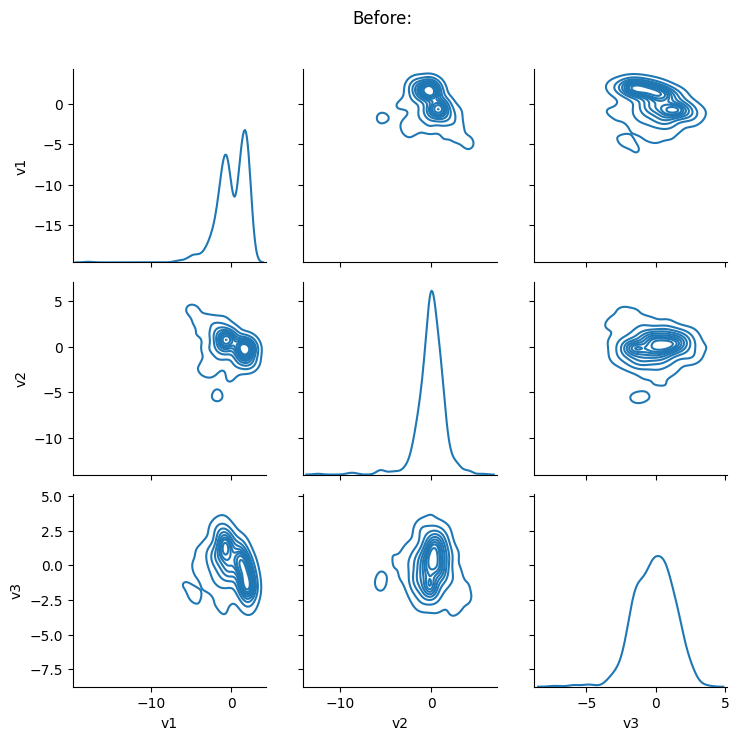

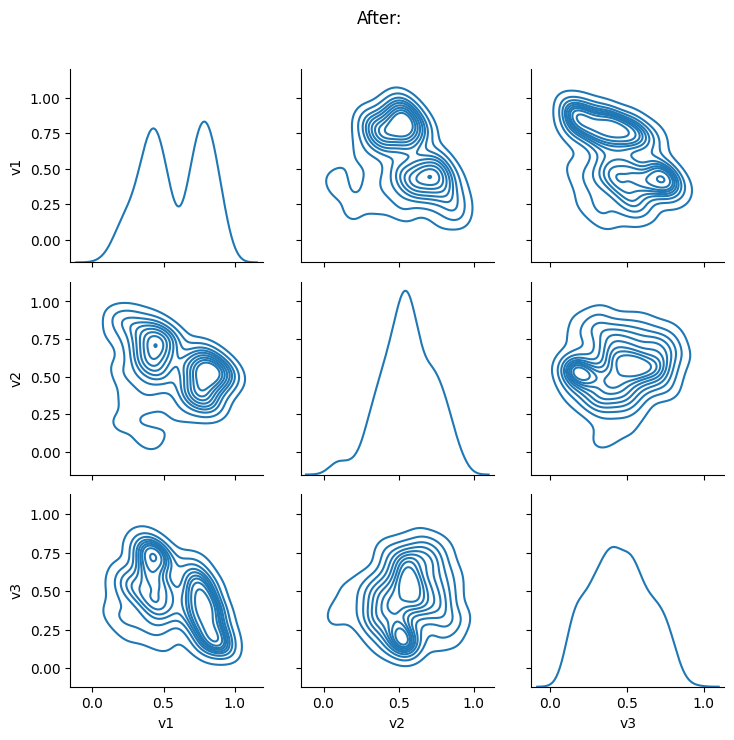

In [29]:
# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fitting the pipeline to the training data to acquire normalization parameters
pipeline.fit(X_train)

# Applying the transformations using the parameters acquired from the training data
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

# Convert the transformed data (which is a NumPy array) back to a Pandas DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train.columns)

# Create a pair grid for the original data (Before transformation)
g_before = sns.PairGrid(X_train.iloc[:, :3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g_before.fig.suptitle('Before:')
g_before.map_diag(sns.kdeplot)
g_before.map_offdiag(sns.kdeplot)

# Create a pair grid for the transformed data (After transformation)
g_after = sns.PairGrid(X_train_transformed_df.iloc[:, :3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g_after.fig.suptitle('After:')
g_after.map_diag(sns.kdeplot)
g_after.map_offdiag(sns.kdeplot)

plt.show()


In [38]:
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define batch size and epochs
BATCH_SIZE = 32  # Adjust as needed
EPOCHS = 50  # Adjust as needed

# Generate timestamp for logging
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# Example: Define a simple autoencoder model
input_dim = X_train_transformed.shape[1]  # Input dimension based on training data

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Create a new directory name for this run based on current time, batch size, and number of layers in the model
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# Define early stopping to halt training when the validation loss stops improving
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    min_delta=0.0001,    
    patience=10,         
    verbose=1,           
    mode='min',          
    restore_best_weights=True  
)

# Define model checkpoint to save the best model weights during training
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.keras',  
    save_best_only=True,  
    monitor='val_loss',   
    verbose=0,            
    mode='min'            
)

# Define TensorBoard callback for visualizing training progress
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{log_subdir}',  
    update_freq='batch'            
)

# List of all the callbacks
callbacks = [early_stop, save_model, tensorboard]

# Train the autoencoder model
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,  
    shuffle=True,  
    epochs=EPOCHS,  
    batch_size=BATCH_SIZE,  
    callbacks=callbacks,  
    validation_data=(X_validate_transformed, X_validate_transformed)  
) 

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 8.5850e-04 - val_loss: 5.7340e-04
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 5.3530e-04 - val_loss: 4.7689e-04
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.6442e-04 - val_loss: 4.3952e-04
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 4.3397e-04 - val_loss: 4.1152e-04
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 4.0780e-04 - val_loss: 3.9804e-04
Epoch 7/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3.9661e-04 - val_loss: 3.8628e-04
Epoch 8/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3.8418e-04 - val_loss: 3.7432e-04
Epoch 9/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3.7610e-04 - val_loss: 3.6817e-04
Epoch 10/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3.7132e-04 - val_loss: 3.6346e-04
Epoch 11/50
5000/5000 ━━━━━━━━━━━━━━━

In [ ]:
# Transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# Pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

# Calculate the mean squared error (MSE) reconstruction loss per row
# mse will be a 1D array where each entry represents the MSE for a single transaction
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
mse

C:\Users\AreebaNadeem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2397/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [32]:
# Predicting the reconstructed values using the autoencoder model
predictions = autoencoder.predict(X_test_transformed)

# Calculating the Mean Squared Error (MSE) for each test sample
mse = np.mean(np.power(X_test_transformed - predictions, 2), axis=1)

# Creating a DataFrame to store the reconstruction errors and true class labels
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

# Summarizing the reconstruction errors
error_df.describe()

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,reconstruction_error,true_class
count,84807.000000,84807.000000
mean,0.000436,0.005801
std,0.001784,0.075946
min,0.000019,0.000000
25%,0.000095,0.000000
50%,0.000159,0.000000
75%,0.000292,0.000000
max,0.032121,1.000000


<div style="background-color: #4caf50; color: white; text-align: center; padding: 15px; border-radius: 5px; font-size: 24px; font-weight: bold;">
Threshold for Classification
</div>


<div style="background-color: #e6ffe6; padding: 20px; border-radius: 10px;">

## 🛠️ **Setting a Threshold for Classification**

In an **unsupervised anomaly detection model**, the goal is to find unusual data points. We set a **threshold** after training the model to decide which points are anomalies.

---

### ⚙️ **Threshold Setting Methods**

1. **🔢 Percentiles**  
   - Select the top **x%** of data points with the **highest reconstruction errors**.  
   - These points are considered anomalies.  

2. **📊 Modified Z-score (MAD)**  
   - Calculate how much each point’s error **differs from the median**.  
   - Points with very high deviations are **anomalies**.  
   - **MAD** is less affected by outliers than percentiles.  

---

### ❓ **Why Use This Model?**

The autoencoder is great for **fraud detection** because:  
- Most transactions are normal.  
- It learns normal patterns and **flags unusual ones**.  
- It works without needing labeled data.  

</div>


In [33]:
THRESHOLD = 3

def mad_score(points):
    """Calculate the Modified Z-score using the Median Absolute Deviation (MAD).
    
    Args:
        points (array-like): Array of data points to calculate MAD for.
        
    Returns:
        np.ndarray: The modified Z-scores for the data points.
    """
    # Compute the median of the points
    median = np.median(points)
    
    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(points - median)
    
    # Compute the MAD (Median Absolute Deviation)
    mad = np.median(abs_deviation)
    
    # Return the Modified Z-scores using the constant 0.6745
    return 0.6745 * abs_deviation / mad

# Calculate the MAD scores for reconstruction errors (mse)
z_scores = mad_score(mse)

# Identify the outliers based on the threshold
outliers = z_scores > THRESHOLD

# Output the results
outliers_count = np.sum(outliers)
total_count = np.size(z_scores)
outliers_percentage = outliers_count / total_count * 100

print(f"Detected {outliers_count:,} outliers in a total of {total_count:,} transactions "
      f"({outliers_percentage:.2f}%).")


Detected 10,744 outliers in a total of 84,807 transactions (12.67%).


In [34]:
# Get the confusion matrix for the true labels and predicted outliers
cm = confusion_matrix(y_test, outliers)

# Extract true/false positives and negatives from the confusion matrix
tn, fp, fn, tp = cm.flatten()

# Calculate precision and recall
precision = tp / (fp + tp) if (fp + tp) > 0 else 0  # Avoid division by zero
recall = tp / (fn + tp) if (fn + tp) > 0 else 0  # Avoid division by zero

# Output the classification results
print(f"""
The classifications using the MAD method with threshold={THRESHOLD} are as follows:
Confusion Matrix:
{cm}

- Percentage of transactions labeled as fraud that were correct (Precision): {precision:.2%}
- Percentage of fraudulent transactions successfully detected (Recall): {recall:.2%}
""")



The classifications using the MAD method with threshold=3 are as follows:
Confusion Matrix:
[[74012 10303]
 [   51   441]]

- Percentage of transactions labeled as fraud that were correct (Precision): 4.10%
- Percentage of fraudulent transactions successfully detected (Recall): 89.63%



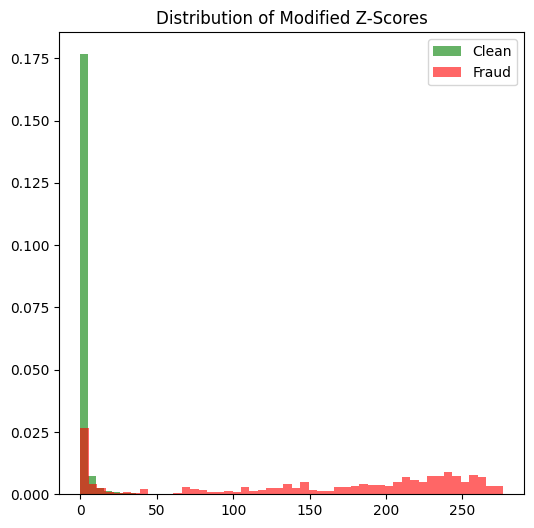

In [35]:
# Separate the z-scores for clean and fraud transactions
clean = z_scores[y_test == 0]
fraud = z_scores[y_test == 1]

# Plotting the distribution of z-scores
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the clean transactions (green)
ax.hist(clean, bins=50, density=True, label="Clean", alpha=0.6, color="green")

# Plot the fraud transactions (red)
ax.hist(fraud, bins=50, density=True, label="Fraud", alpha=0.6, color="red")

# Adding title and legend
plt.title("Distribution of Modified Z-Scores")
plt.legend(loc="best")

# Display the plot
plt.show()


In [36]:
# We're using the first 5 layers of the autoencoder to create a model for dimensionality reduction.
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,997 (31.24 KB)

 Trainable params: 7,997 (31.24 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
<div style="background-color: #fff5cc; padding: 20px; border-radius: 10px;">

## 🔍 **Conclusion: Outlier Detection for Fraudulent Transaction Detection**

This project explored how an **autoencoder model** can detect **fraudulent transactions** by learning to reconstruct **normal transactions**.  
- **Anomalies** were identified using the **modified Z-score** of the **reconstruction error**.  
- This method helps when **labeled fraud data** isn’t available.

---

### 🛠️ **Additional Models Used**

We applied **three unsupervised models** to detect outliers:  
1. 🌲 **Isolation Forest**  
2. 📍 **Local Outlier Factor (LOF)**  
3. ⚙️ **One-Class SVM**  

While these models reached about **95% accuracy**, they often:  
- **Misclassified fraudulent transactions** as normal.  
- **Struggled with class imbalance**, where **fraud cases** are **rare**.

---

### 📈 **Key Insights**

The models performed well in **accuracy** but were **less effective for fraud detection** due to:  
- **Imbalanced dataset** (few fraud cases).  
- **Low precision** in detecting **fraudulent transactions**.

---

### 🚀 **Recommendations**

To improve fraud detection:  
- Use **class balancing** techniques like **SMOTE** or **undersampling**.  
- **Evaluate performance** using **Precision-Recall curves**.  
- Apply **ensemble-based anomaly detection methods** for better results.

By **reducing imbalance** and **improving evaluation**, these models can more **accurately detect fraudulent transactions**.

</div>


SyntaxError: invalid character '’' (U+2019) (2797500361.py, line 7)